# 17. 난 스케치를 할 테니 너는 채색을 하거라

### Segmentation map으로 도로 이미지 만들기

![](https://d3s0tskafalll9.cloudfront.net/media/images/p2p_result_seg.max-800x600.png)

U-Net GAN을 이용해 Pix2Pix로 도로의 레이블 정보를 활용해 이미지를 생성해보자. 

U-Net의 Generator 구조는 다음과 같다.   
![](https://d3s0tskafalll9.cloudfront.net/media/images/p2p_generator_unet.max-800x600.png)

Encoder, Decoder로 구성된 Generator와 다른 점은, 각 레이어마다 Encoder와 Decoder가 연결(skip connection)되어있다.   
Decoder가 변환된 이미지를 더 잘 생성하도록 Encoder로부터 더 많은 추가 정보를 이용하는 방법이며, 이러한 U-Net 구조의 유무에 따라 결과물이 크게 차이난다.   
![](https://d3s0tskafalll9.cloudfront.net/media/images/p2p_result_g.max-800x600.png)

Discriminator는 이미지의 receptive field 영역을 지정해서 전체 이미지의 진짜, 가짜를 판별하는게 아닌 일부 영역의 진짜, 가짜를 나타내는 여러 확률값을 계산하는 PatchGAN을 사용하자.   
![](https://d3s0tskafalll9.cloudfront.net/media/images/patchgan_results.max-800x600.png)

286x286 사이즈의 입력 이미지를 넣어 filter 사이즈를 정해 만든 결과물이다.   
너무 작은 patch를 사용하면 품질이 좋지 않고, 70x70의 결과물이 너무 큰 286x286 보다 조금 더 사실적인 이미지를 생성하므로 PatchGAN의 사용이 성공적이라 볼 수 있다.



### 프로젝트 수행

프로젝트를 수행하면서 필수로 수행해야 할 사항은 다음과 같다.
1. 데이터에 한 가지 이상의 augmentation 방법을 적용하자
2. study에서 구현했던 두 개의 Generator중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용하자
3. 모델 학습 후, 학습된 Generator를 이용해 테스트하자. 테스트 데이터는 'val' 폴더 내 이미지를 사용하자.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 시각화 해주자
5. 모델을 충분히 학습하기에 시간이 부족할 수 있다. 적어도 10에포크 이상 학습하며 중간 손실 값에 대한 로그를 남겨주자.

# 1. 데이터 준비 및 전처리

In [ ]:
import os

data_path = '/content/drive/MyDrive/aiffel_dataset/conditional_generation/cityscapes/train/'
val_path = '/content/drive/MyDrive/aiffel_dataset/conditional_generation/cityscapes/val/'
print(data_path)
print("number of train examples :", len(os.listdir(data_path)))
print("number of val examples :", len(os.listdir(val_path)))

/content/drive/MyDrive/aiffel_dataset/conditional_generation/cityscapes/train/
number of train examples : 1000
number of val examples : 5


데이터셋에서 임의로 6장을 선택해서 시각화해보자.


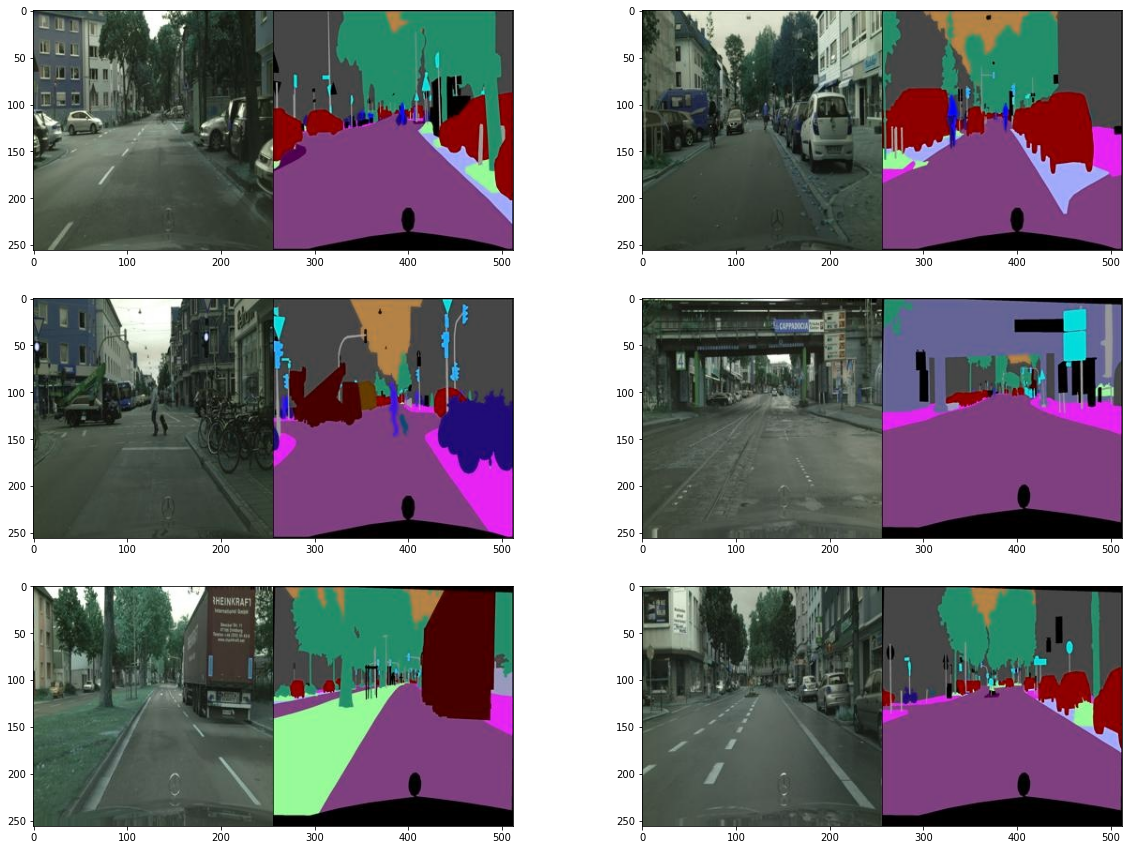

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

(256, 512, 3)


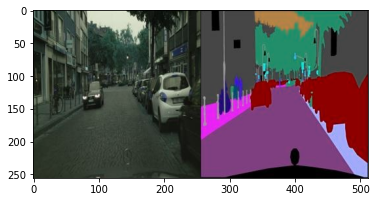

In [ ]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)
plt.imshow(img)

우측의 segmentation을 넣어 좌측의 원본처럼 만들어야 한다.   

256, 256으로 좌, 우 이미지를 분할하자. 그리고 train sample이 1000개 밖에 안되므로 augmentation 방법을 적용해 데이터셋 크기를 키우자.

Text(0.5, 0, 'original image')

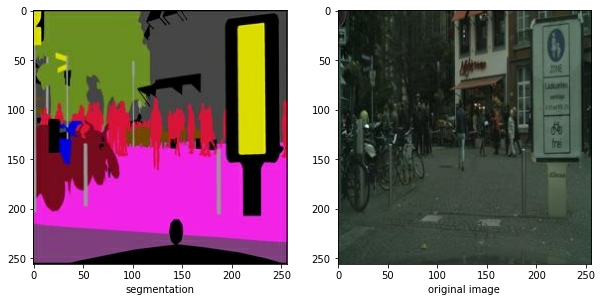

In [ ]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32) # segmentation
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32) # original image
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.xlabel("segmentation")
plt.subplot(1,2,2); plt.imshow(denormalize(colored))
plt.xlabel("original image")

In [ ]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

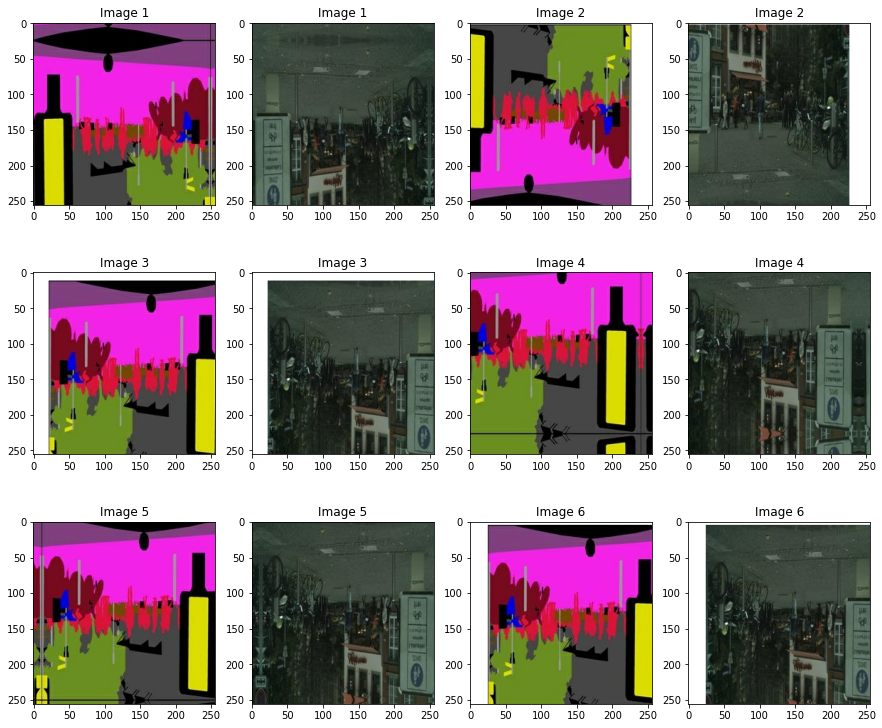

In [ ]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

- 이미지를 채널 축으로 concat한다. 두 이미지가 각각 3채널인 경우 6채널이 된다.
- 위의 결과에 50% 확률로 refection 또는 constant padding이 30픽셀의 pad width만큼 적용된다.
- 위 결과에 256, 256 ,6 크기를 가진 이미지를 임의로 잘라낸다.
- 위 결과를 50% 확률로 가로로 뒤집는다.
- 위 결과를 50% 확률로 세로로 뒤집는다.
- 위 결과를 50% 확률로 회전한다.

위 과정들을 학습 데이터에 적용하여, 잘 적용되었는지 이미지 하나만 시각화하여 확인해보자.

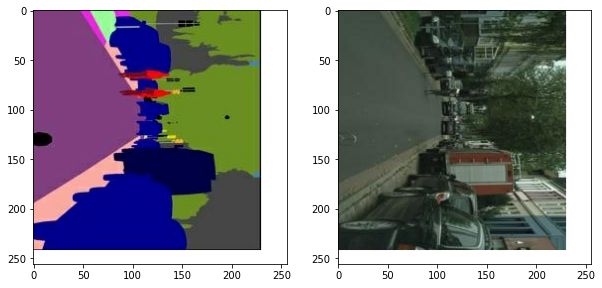

In [ ]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# 2. U-Net Generator 구성하기

![](https://d3s0tskafalll9.cloudfront.net/media/images/refer_g.max-800x600.png)

위 그림의 ENCODE와 DECODE 노드를 기준으로 이미지 크기가 작아졌다가 커지는걸 볼 수 있다. 채널의 개수는 반대로 움직인다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/p2p_result_g2.max-800x600.png)

단순한 Encoder-Decoder에 비해 U-Net 구조가 훨씬 더 실제 이미지에 가까운 품질을 보인다. 그러므로 EncodeBlock과 DecodeBlock을 선언해 U-Net 구조를 만들고 실험해보자.

In [ ]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [ ]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

먼저 encode, decode block이 차례대로 `call()` 내부에서 연산을 수행한다. 이 때 이 둘 사이에 skip connection을 위해 `features` 리스트를 만들고 Encoder 내에서 사용된 블록들의 출력을 차례대로 담았다.   

Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각 Decoder 블록들을 통과하는데, `features` 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용된다.

`get_summary()`를 이용해서 (256,256,3) 데이터를 선언했다. `UNetGenerator()` model을 확인해보자.

In [ ]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

# 3. Discriminator 구성하기

![](https://d3s0tskafalll9.cloudfront.net/media/images/refer_d.max-800x600.png)

진짜 및 가짜 이미지를 판별하기 위해 최종 출력에 sigmoid를 사용했다.

2개의 입력 in, unknown을 받아 CONCAT한 후 ENCODE 노드 5개를 통과한다. 마지막 ENCODE 노드 제외하고 나머지 4개는 논문에서 표기된 C64-128-256-512를 말한다. 마지막은 1차원 출력을 위한 블록이 추가됐다.

최종적으로 출력되는 크기는 (30,30,1)이며 출력 이전의 노드는 출력의 크기가 32,31,30으로 1씩 감소하는 특징을 볼 수 있다.

최종 출력 크기가 (30,30,1)이 되어야 하는 이유는 70x70 PatchGAN을 사용했기 때문이다. 최종 (30,30) 출력에서 각 픽셀의 receptive field 크기를 (70,70)으로 맞추기 위해 discriminator 출력 크기를 (30,30) 크기로 강제로 맞추는 과정이다.

Convolution layer에서 kernel 크기, stride, padding 등을 토대로 출력 크기를 계산했던 방식을 사용하면 계산할 수 있다.

In [ ]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [ ]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_15 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

이렇게 설정하면 Discriminator의 마지막 ENCODE 3개 width, height 1 픽셀씩 주는 과정을 적용할 수 있다.

Pix2Pix가 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30,30) 크기로 맞추느라 조금 복잡한 과정이다. 이 블록을 이용해 Discriminator를 만들자.

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [ ]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

# 4. 학습 및 테스트

![](https://d3s0tskafalll9.cloudfront.net/media/images/p2p_result_loss2.max-800x600.png)

GAN 손실함수에 L1을 같이 사용했을 때 결과물이 가장 좋다. 이번에도 두 가지 손실함수를 모두 사용해보자.

In [ ]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

- get_gene_loss는 3개의 입력이 있다. `fake_disc`는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이고, 실제 이미지를 뜻하는 `1`과 비교하기 위해 `tf.ones_like()`를 사용한다. L1 손실을 계산하기 위해 생성한 가짜이미지와 실제 이미지 사이의 MAE(Mean Absolute Error)를 계산한다.
- Discriminator의 손실함수 `get_dise_loss`는 2개의 입력이 있으며, 이들은 진짜, 가짜 이미지가 Discriminator에 입력되어 얻어진 값이다. 진짜 이미지는 1로 채워진 벡터와 비교하교, 가짜는 0으로 채워진 벡터와 비교한다.

In [ ]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [ ]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8861                     
L1_loss:0.3704                     
Discriminator_loss:1.2456

EPOCH[1] - STEP[20]                     
Generator_loss:0.9832                     
L1_loss:0.2749                     
Discriminator_loss:1.3484

EPOCH[1] - STEP[30]                     
Generator_loss:0.7339                     
L1_loss:0.1747                     
Discriminator_loss:1.2545

EPOCH[1] - STEP[40]                     
Generator_loss:1.1186                     
L1_loss:0.2028                     
Discriminator_loss:1.5085

EPOCH[1] - STEP[50]                     
Generator_loss:1.2811                     
L1_loss:0.1844                     
Discriminator_loss:1.2772

EPOCH[1] - STEP[60]                     
Generator_loss:1.0236                     
L1_loss:0.2142                     
Discriminator_loss:1.1687

EPOCH[1] - STEP[70]                     
Generator_loss:1.1924                     
L1_loss:0.1738                    

In [ ]:
# test_ind = 0

for i in range(0, 5):
    # f = data_path + os.listdir(data_path)[test_ind]
    f = val_path + os.listdir(val_path)[i]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

Output hidden; open in https://colab.research.google.com to view.

# 5. 결과

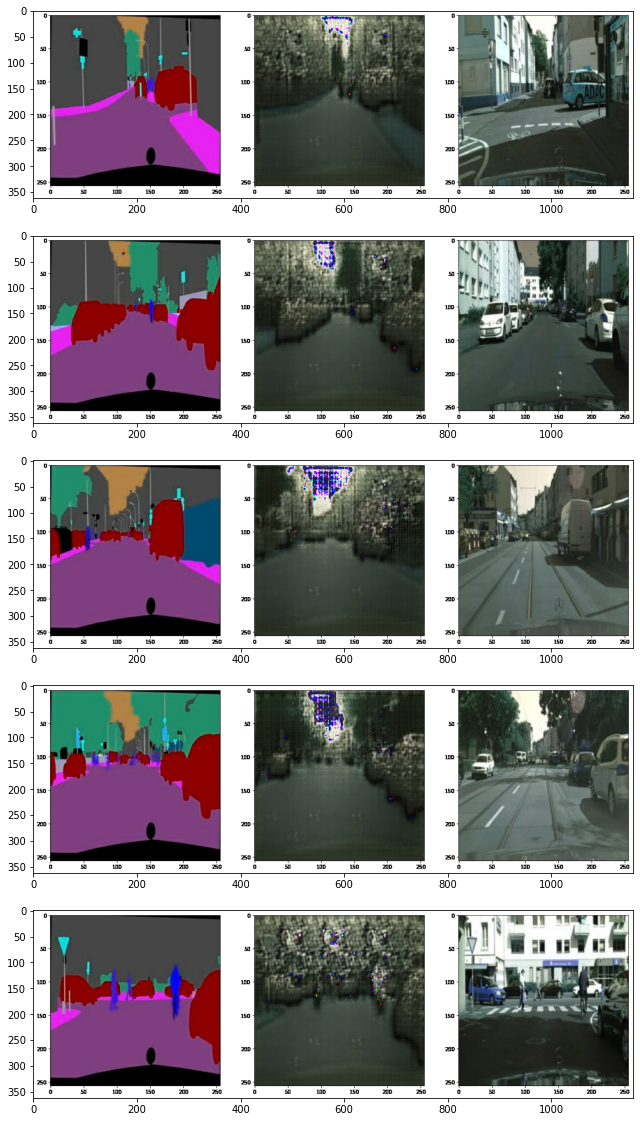

In [20]:
result_path = '/content/drive/MyDrive/aiffel_dataset/conditional_generation/result/'

plt.figure(figsize=(30,20))
for i in range(0,5):
    f = result_path + os.listdir(result_path)[i]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(5,1,i+1)
    plt.imshow(img)

# 5. 회고

- GAN 네트워크의 label 타겟팅을 위해 탄생한 cGAN
- Pix2Pix 개념의 encoder-decoder generator
- 결과물을 더 사실적으로 만들기 위해 나온 U-Net generator
- Pix2Pix의 discriminator
- discriminator가 하나의 이미지를 보는게 아닌 receptive field를 보는 PatchGAN

이번 프로젝트는 새롭게 만들어 내는데 중점을 두기보다, GAN이라는 기술을 이해하고 사용하는데 중점을 두고 진행했다.

노드가 엄청 상세하게 나와있어 이해하는데 많은 도움이 되었다. 하지만 이해안되는 부분도 조금 있다.   

agumentation 하는 과정에서 좌, 우 이미지를 2개로 나누는데 이를 설명할 때 concatination을 한다고 3채널이 6채널이 된다고 말했다. 이미지를 concat하면 stack의 형식이 아닌 일자로 펴진다고 생각을 하고 있었는데, 조금 다른가보다.   
reflect, constant padding을 한다고 하는데 constant는 검색해보니 0으로 바깥쪽을 감싸주는 것임을 알았다. reflect는 중심을 기점으로 filter 사이즈의 영향을 받아 padding 영역에 숫자를 채운다는 걸 알겠는데 실제 이미지에선 어떻게 적용이될까? 9번째 코드블럭에 결과물이 나와있는데 끝 부분에 mirror 효과처럼 적용된걸 볼 수 있다. 이것을 의미하는거 같은데 실제 숫자가 어떻게 적용됐는지 궁금하다.
~~cs231n 학습 과정에서 배운거같은데..!!~~

학습하는데 시간이 너무 오래 걸린다. 그래서 GAN을 상업적으로 사용한 사례가 있는지 궁금해져 서치해봤다. 상업적은 아니고 카카오테크에서 가상세계에서 사용할 얼굴 합성인 페이스 스와핑 기술을 준비하고 있는걸 확인할 수 있었다. 그리고 이를 응용한 연예인 카메라 필터를 만들면 꽤 괜찮은 결과물이 나오지 않을까? 하고 생각했다.   

연구는 흥미롭고 재미있는 주제가 많지만, 이를 토대로 실제 상업적 용도로 쓰이는 사례는 많이 없는거 같다. 